In [3]:
import json

file_path = "../Data/recipes.json"
with open(file_path, "r",encoding='utf-8') as file:
    data = json.load(file)

In [4]:
len(data)

200

In [5]:
import sys
sys.path.append('..')

In [6]:
from minbpe import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load(model_file="../Data/tokenizer/my_tokenizer.model")


def get_vocab_size(tokenizer: RegexTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

In [7]:
tokenized_data = []
for item in data:
    tokenized_item = tokenizer.encode(item, allowed_special="all")
    tokenized_data.append(tokenized_item)

len(tokenized_data[0])

10

In [8]:
# initial_split_index = int(0.9 * len(data))

# # Adjusting the index to ensure that the training set ends with "Assistant" message
# # and that the validation set starts with "You" message

# # Scanning backward to find an Assistant message
# split_index = initial_split_index
# while split_index > 0 and not data[split_index-1].startswith('<|startoftext|>Assistant'):
#     split_index -= 1

# train_data = data[:split_index]
# val_data = data[split_index:]

# print("Training set: ")
# print(f"Start message: {train_data[0].split('<|separator|>')[0]}")
# print(f"End message: {train_data[-1].split('<|separator|>')[0]}")

# print("\nValidation set: ")
# print(f"Start message: {val_data[0].split('<|separator|>')[0]}")
# print(f"End message: {val_data[-1].split('<|separator|>')[0]}")

In [9]:
initial_split_index = int(0.9 * len(data))

split_index = initial_split_index
while split_index > 0 and not data[split_index-1].startswith('<|startoftext|>Assistant'):
    split_index -= 1

# If no Assistant found, fallback to initial_split_index
if split_index == 0:
    split_index = initial_split_index

train_data = data[:split_index]
val_data = data[split_index:]

print("Training set:")
if train_data:
    print(f"Start message: {train_data[0].split('<|separator|>')[0]}")
    print(f"End message: {train_data[-1].split('<|separator|>')[0]}")
else:
    print("⚠️ train_data is empty!")

print("\nValidation set:")
if val_data:
    print(f"Start message: {val_data[0].split('<|separator|>')[0]}")
    print(f"End message: {val_data[-1].split('<|separator|>')[0]}")
else:
    print("⚠️ val_data is empty!")


Training set:
Start message: <|startoftext|>Person 1
End message: <|startoftext|>Person 2

Validation set:
Start message: <|startoftext|>Person 1
End message: <|startoftext|>Person 2


In [10]:
train_data = tokenized_data[:split_index]
val_data = tokenized_data[split_index:]

In [11]:
block_size = 128


def combine_turns(data: list[list[int]], should_trim_long_sequences: bool) -> list[list[int]]:
    combined_turns_data = []
    for i in range(0, len(data)-1, 2):
        you_message = data[i]
        assistant_message = data[i+1]
        if not you_message or not assistant_message:
            continue

        final_message = you_message + assistant_message
        if len(final_message) > block_size and should_trim_long_sequences:
            final_message = final_message[-block_size:]

        combined_turns_data.append(final_message)
    return combined_turns_data


combined_train_data = combine_turns(
    data=train_data,
    should_trim_long_sequences=True
)
combined_val_data = combine_turns(
    data=val_data,
    should_trim_long_sequences=True
)

In [12]:
print("Train data")
print(f"Length before: {len(train_data)}")
print(f"Length after: {len(combined_train_data)}")

print("\nValidation data")
print(f"Length before: {len(val_data)}")
print(f"Length after: {len(combined_val_data)}")

Train data
Length before: 180
Length after: 90

Validation data
Length before: 20
Length after: 10


In [13]:
import torch

train_data = torch.tensor(combined_train_data)
val_data = torch.tensor(combined_val_data)

ValueError: expected sequence of length 91 at dim 1 (got 75)

In [14]:
import torch
torch.manual_seed(3647)

# The token `<|padding|>` is used to mask the padding tokens.
# Masking means the model will ignore these tokens during training.
# In other words, the loss will not be calculated for these tokens.
padding_token = tokenizer.special_tokens["<|padding|>"]


def apply_padding_to_data(data: list[list[int]], block_size: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input=tensor,
            # for right padding:
            pad=(0, block_size - len(tensor)),
            # pad=(block_size - len(tensor), 0),
            value=padding_token
        )
        tensors.append(padded_tensor)

    return torch.stack(tensors)


train_data_tensor = apply_padding_to_data(
    data=combined_train_data,
    block_size=block_size,
    padding_token=padding_token
)
val_data_tensor = apply_padding_to_data(
    data=combined_val_data,
    block_size=block_size,
    padding_token=padding_token
)

train_data_tensor.shape, val_data_tensor.shape

(torch.Size([90, 128]), torch.Size([10, 128]))

In [15]:
train_data_tensor[0]

tensor([1024,   80,  259,  115,  276,   32,   49, 1025,  963, 1026, 1024,   80,
         259,  115,  276,   32,   50, 1025,  346,   32,  437,   44,  289,  297,
         308,  339,  438,   44,  517,   44,   32,  258,  100,  285,  439,   46,
          32,  466,  107,  320,   32,  322,   44,   32,  304,   44,   32,  258,
         100,   32,  415,  116,  537,  525,   46,   32,  330,  107,   32,  276,
          32,   97,   32,  468,  469,   32,  299,  289,  577,  399,  271,  704,
         340,  109,   44,   32,  369,  578,   44,   32,  258,  100,  285,  474,
          32,  268,  104,  285,  418,   46, 1026, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028])

In [16]:
val_data_tensor[0]

tensor([1024,   80,  259,  115,  276,   32,   49, 1025,   77,  111,  106,  737,
          32,   40,   77,  111,   99,  107,  839,  261,   41, 1026, 1024,   80,
         259,  115,  276,   32,   50, 1025,   77,  617,  108,  101,   32,  868,
         116,   32,  258,  100,   32,  620,  326,   44,   32,  312,  100,  285,
         111,  100,   97,  785,   32,  258,  100,   32,  302,   46, 1026, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028])

In [17]:
train_data_tensor.shape

torch.Size([90, 128])

In [18]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        return x, y


batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data_tensor,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = FineTuningDataset(
    data=val_data_tensor,
    device=device,
    padding_token=padding_token
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [19]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([64, 128]), torch.Size([64, 128]))

In [26]:
from transformer.model import GPTLanguageModel

block_size = 256
n_embd = 512
n_head = 4
n_layer = 1
dropout = 0.2
batch_size = 64
vocab_size = get_vocab_size(tokenizer)

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)
model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

4.342794 M parameters


In [27]:
checkpoint_path = "../Data/pre_training/run_1/checkpoint_19.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [29]:
input_tokens = tokenizer.encode("Pancakes ", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

Pancakes tional egg or tomato slices.
  Shakshuka: Cook onion, garlic, and peppers. Add tomatoes and spices. Crack eggs into sauce, cover, and cook until set. Serve with bread.
  Banana Smoothie: Blend banana, milk, honey, and ice until smooth. Serve chilled.
  Oatmeal: Cook oats in milk/honey and top with fruits and nuts.
  Breakfast Burrito: Scramble eggs with veggies, beans, and cheese. Roll inside a tortilla and serve warm.
  S


In [30]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = []
        for x, y in loader:
            with torch.no_grad():
                _, loss = model(x, y)
            losses.append(loss.item())
        output[split] = sum(losses) / len(losses)

    model.train()
    return output

In [31]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

In [32]:
import os
import warnings

# --- Disable Triton checks ---
os.environ["TORCHINDUCTOR_DISABLE_TRITON"] = "1"

# --- Suppress TorchDynamo / Inductor warnings ---
warnings.filterwarnings("ignore", category=UserWarning)

# Optional: fully disable TorchDynamo verbose logging
import torch._dynamo as dynamo
dynamo.reset()
dynamo.config.verbose = 0
dynamo.config.suppress_errors = True

In [33]:
max_iters = 5
eval_interval = 3
learning_rate = 6e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"../Data/fine_tuning/run_3/checkpoint_{iteration}.pth"
    )

W0903 20:56:39.176992 11052 site-packages\torch\_inductor\utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode
W0903 20:56:39.527943 11052 site-packages\torch\_dynamo\convert_frame.py:1280] WON'T CONVERT forward d:\WORK space\LLm\NoteBook\..\transformer\model.py line 129 
W0903 20:56:39.527943 11052 site-packages\torch\_dynamo\convert_frame.py:1280] due to: 
W0903 20:56:39.527943 11052 site-packages\torch\_dynamo\convert_frame.py:1280] Traceback (most recent call last):
W0903 20:56:39.527943 11052 site-packages\torch\_dynamo\convert_frame.py:1280]   File "c:\Users\Altai\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_dynamo\convert_frame.py", line 1213, in __call__
W0903 20:56:39.527943 11052 site-packages\torch\_dynamo\convert_frame.py:1280]     result = self._inner_convert(
W0903 20:56:39.527943 11052 site-packages\torch\_dynamo\convert_frame.py:1280]   File "c:\Users\Altai\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_dynamo\convert_f

iteration 0 / step 0: train loss 7.7414, val loss 8.0894
iteration 0 / step 1: train loss 6.8644, val loss 7.2008
iteration 1 / step 0: train loss 6.0779, val loss 6.4758
iteration 1 / step 1: train loss 5.7945, val loss 6.2073
iteration 2 / step 0: train loss 5.5618, val loss 6.0289
iteration 2 / step 1: train loss 5.2637, val loss 5.6862
iteration 3 / step 0: train loss 4.9428, val loss 5.3299
iteration 3 / step 1: train loss 4.7624, val loss 5.0804
iteration 4 / step 0: train loss 4.5898, val loss 4.9262
iteration 4 / step 1: train loss 4.4659, val loss 4.8086


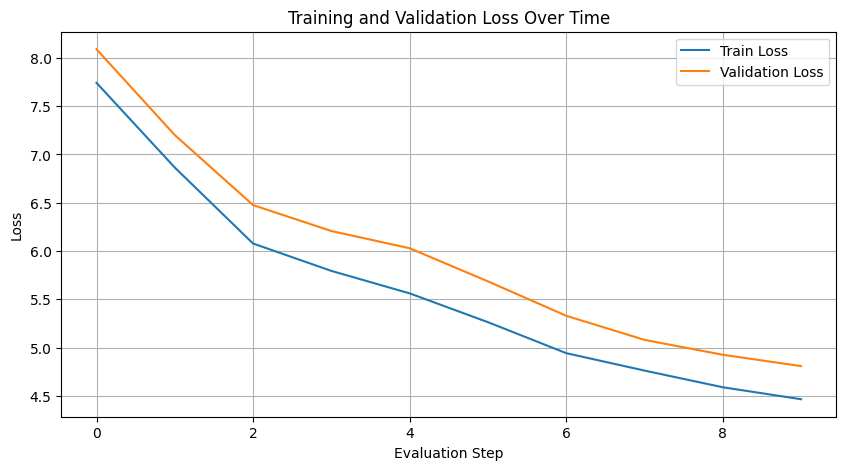

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [37]:
def get_input_tokens(message: str) -> torch.Tensor:
    input_tokens = tokenizer.encode(
        f"<|startoftext|>{message}<|separator|>", allowed_special="all")
    input_tokens = torch.tensor(
        input_tokens, dtype=torch.long).unsqueeze(0).to(device)
    return input_tokens


user_message = "Pancakes"
input_tokens = get_input_tokens(message=user_message)
model_answer = ""

model.eval()
while True:
    output_tokens = model.generate(input_tokens=input_tokens, max_new_tokens=1)
    last_generated_token = output_tokens[0, -1].item()
    if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
        break

    input_tokens = torch.cat((input_tokens, output_tokens[:, -1:]), dim=1)
    model_answer += tokenizer.decode([last_generated_token])

    if len(output_tokens[0]) > block_size:
        input_tokens = input_tokens[:, -block_size:]

print(f"You: {user_message}")
print(f"Assistant: {model_answer}")

ValueError: invalid token id: 1032